
# Introduction

---
Up to this point, we’ve covered the foundational concepts of machine learning. You may have already experimented with various hyperparameters to optimize model performance. In this notebook, you’ll be introduced to several advanced techniques designed to further enhance your models.


This notebook consists the following parts:

- [A: Data retrieval ](#01)
- [B: Feature engineering](#02)
- [C: Model evaluation](#03)
- [D: Ensemle learning](#04)
- [E: Pipelines](#05)
- [F: Bring it all together](#06)
- [G: Bonus: ML OPS](#07)


---

### Learning Objectives
By the end of this two weeks you will be able to:
- Understand the fundamental concepts of ensemble learning.
- Use evaluation techniques to assess models performance.
- Enhance model performance by feature engineering. 
- Build pipelines for model development and preprocessing

---

### Instructions
- Ensure you fully understand the requirements and objectives of the assignment.
- Review the notebooks refered in the tasks
- If you need additional context or clarification, please check the provided videos or background literature.
- Work through each part of the assignment methodically, ensuring all tasks are completed.
- Update your repository with your new created work

### Additional Notes:
- Do not add datafiles to your repository. Repositories with datafiles will not be accepted
- Class solutions should be delivered in python files. Not in notebooks
- When AI tools are used, you must provide proper references and explanations for how they were utilized. Failure to do so will be considered as academic fraud
- The bonus assignment are not mandatory
- Use PEP8 

Good luck!

F.Feenstra

---


<a name='01'></a>
## Part A. Data retrieval

The dataset you can use for this notebook is the lung dataset from Maastricht University. It comprises 89 non-small cell lung cancer (NSCLC) patients records who underwent surgical treatment. The study where the data is from explored the relationship between radiomic imaging features and gene expression profiles. The samples were collected through biopsies at MAASTRO Clinic in The Netherlands, and the dataset is publicly available.

The authors of the related paper discovered that a prognostic radiomic signature, which captures intra-tumor heterogeneity, is closely associated with underlying gene expression patterns. Developing a machine learning model to predict histology from the Clinical and Genetic Lung data can improve diagnostic accuracy and treatment personalization. In this notebook we will develop such a prediction model. 

**Availabel Datasets**:
- Lung metadata dataset [1]
- Gene expression dataset [2]

**Important**
<span style="background-color: lightgreen;color: black">It is also allowed to use your own dataset from your own project if this data is highly dimensional and contains genetic information.</span>

[1] [NSCLC-Radiomics-Genomics](https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics-Genomics#16056856db10d39adf704eefa53e41edcf5ef41c)

[2] [Gene Expression Data - GSE58661](https://ftp.ncbi.nlm.nih.gov/geo/series/GSE58nnn/GSE58661/matrix/)

[3] Aerts HJWL, Rios Velazquez E, Leijenaar RTH, Parmar C, Grossmann P, Carvalho S, Bussink J, Monshouwer R, Haibe-Kains B, Rietveld D, Hoebers F, Rietbergen MM, Leemans CR, Dekker A, Quackenbush J, Gillies RJ, & Lambin P. (2015). Data From NSCLC-Radiomics-Genomics. The Cancer Imaging Archive. https://doi.org/10.7937/K9/TCIA.2015.L4FRET6Z


### <span style="background-color: lightyellow;">Data retrieval task</span>
- Retrieve the data. (No cleaning needed yet)

In [3]:
# YOUR CODE HERE TO DEMONSTRATE THE USAGE OF THE PREPROCESSOR CLASS
import pandas as pd
data = pd.read_table("./GSE58661_series_matrix.txt.gz", sep='\t', header=1, skipfooter=1, skiprows=61, engine='python')
metadata = pd.read_excel("./Lung3.metadata.xls")

---
<a name='02'></a>
## Part B. Feature engineering

Mind you that choosing an algorithm and hyperparameter tuning might not be enough. If your data is of low quality, the algorithm will have poor performance as well. This is where feature engineering comes into play. Feature engineering involves transforming raw data into meaningful features that better represent the underlying problem to the predictive models, ultimately enhancing the model's performance. By selecting, creating, and refining features, you ensure that your data highlights the most relevant patterns and relationships, allowing the algorithm to learn more effectively. Proper feature engineering can often make the difference between a moderate model and a highly accurate one, even more so than the choice of algorithm itself. 
Possible modifications:
- creation of new features derived from original features
- selection of features
- encoding features
- logtransformation 
- scaling
- dimension reduction (PCA)

### <span style="background-color: lightyellow;">Feature engineering Task</span>
- Review the [Study Case Feature Engineering notebook](../Study_Cases/study_case_feature_engineering.ipynb).
- Review the [Study Case RNA-seq Preparation notebook](../Study_Cases/study_case_scanpy_object.ipynb).
- Assess which data preparation and feature engineering steps could be beneficial for your dataset.
- Implement a `DataProcessor` class tailored to your dataset and test it in the cell below.
- Update your repository with a new directory named `optimization`, including the following:
    - The `DataProcessor` class as a Python file, complete with thorough documentation.
    - An evaluation document that details and justifies your choices using a well-reasoned, argumentative approach.



In [85]:
from sklearn.preprocessing import Normalizer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

class DataProcessor:

    selected_features = ['source.location', 
                         'characteristics.tag.gender',
                         'characteristics.tag.tumor.size.maximumdiameter',
                         'characteristics.tag.stage.primary.tumor',
                         'characteristics.tag.stage.nodes', 
                         'characteristics.tag.stage.mets'] 

    def __init__(self):
        self.normalizer = Normalizer()
        self.scaler = StandardScaler()
        self.oh_encoder = OneHotEncoder()
        self.ordinal_encoder = OrdinalEncoder()
        # keep 95% of varaince
        self.pca = PCA(n_components = .95)

    def preprocess_gene_data(self, X):
        # format
        formatted = X.iloc[:,1:].T
        # normalize
        normalized = self.normalizer.fit_transform(formatted)
        # scale
        scaled = self.scaler.fit_transform(normalized)
        # reduce
        reduced = self.pca.fit_transform(scaled)
        reduced = pd.DataFrame(reduced)
        reduced.columns = [f"PCA_{i}" for i in reduced.columns]
        return reduced
    
    def preprocess_meta_data(self, meta):
        # separate numeric features
        numeric = "characteristics.tag.tumor.size.maximumdiameter"
        diameter = meta[numeric]
        meta = meta.drop(columns=numeric)
        # encode labels to integers
        encoded = self.ordinal_encoder.fit_transform(meta)
        # reconbine the dataframes
        encoded_meta = pd.DataFrame(encoded)
        encoded_meta.columns = meta.columns
        encoded_meta["diameter_tumor"] = diameter
        return encoded_meta
    
    def clean_metadata(self, meta):
        # subset selected features
        meta = meta[self.selected_features]
        # convert all to upper
        meta.iloc[:,-3:] = meta.iloc[:,-3:].apply(lambda col: col.str.upper())
        # fill nans with average
        avg = meta["characteristics.tag.tumor.size.maximumdiameter"].mean()
        meta.iloc[:,2] = meta.iloc[:,2].fillna(avg)        
        return meta
    
    def merge_gene_meta(self, X, meta):
        return meta.merge(X, how="inner", left_index=True, right_index=True)
    
    def fit_transform(self, X, metadata):
        meta = self.clean_metadata(metadata)
        preprocessed_meta = self.preprocess_meta_data(meta)
        preprocessed_genetic = self.preprocess_gene_data(X)
        merged_dataset = self.merge_gene_meta(preprocessed_genetic,
                                              preprocessed_meta)
        return merged_dataset


In [86]:
pr = DataProcessor()
processed_data = pr.fit_transform(data, metadata)
display(processed_data.head())
display(processed_data.info())

,source.location,characteristics.tag.gender,characteristics.tag.stage.primary.tumor,characteristics.tag.stage.nodes,characteristics.tag.stage.mets,diameter_tumor,PCA_0,PCA_1,PCA_2,PCA_3,...,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,PCA_72,PCA_73,PCA_74,PCA_75
0,0.0,1.0,3.0,0.0,0.0,4.000000,17.684689,140.712948,-74.343599,-30.547522,...,-18.614642,-34.182512,-20.946600,-2.082617,-5.398676,2.019621,-8.220528,-19.167325,-21.072501,5.767235
1,0.0,1.0,0.0,3.0,2.0,1.300000,-43.263475,-128.669053,-25.987261,-90.228322,...,-6.136728,-13.063613,-4.033333,4.840130,-1.254953,-3.529313,4.509437,10.151877,1.056062,-1.061530
2,0.0,1.0,6.0,0.0,0.0,11.000000,-63.820807,45.764603,-6.358352,-22.619427,...,2.325631,17.682200,-6.628825,-5.003987,1.512437,-2.273532,0.593036,-4.846011,3.611907,1.763883
3,0.0,1.0,8.0,3.0,1.0,4.403409,129.991407,13.658345,-11.701364,-153.316807,...,3.501878,-34.011474,18.988320,-4.034644,14.973310,-15.770275,8.554998,7.132255,3.266267,-2.042651
4,0.0,0.0,6.0,0.0,0.0,7.800000,-63.388114,10.759819,-33.793759,41.552763,...,-39.578056,32.728723,-1.299953,23.147889,-10.473817,15.191755,-7.313738,20.245346,-35.815401,-2.774167


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 82 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   source.location                          89 non-null     float64
 1   characteristics.tag.gender               89 non-null     float64
 2   characteristics.tag.stage.primary.tumor  89 non-null     float64
 3   characteristics.tag.stage.nodes          89 non-null     float64
 4   characteristics.tag.stage.mets           89 non-null     float64
 5   diameter_tumor                           89 non-null     float64
 6   PCA_0                                    89 non-null     float64
 7   PCA_1                                    89 non-null     float64
 8   PCA_2                                    89 non-null     float64
 9   PCA_3                                    89 non-null     float64
 10  PCA_4                                    89 non-null

None

<a name='03'></a>
# Part C. Model Evaluation

Evaluating the performance of a machine learning model goes beyond just looking at accuracy, as accuracy alone can be misleading, especially in cases where the dataset is imbalanced or where different types of errors have different consequences
- **Detecting Overfitting/Underfitting**: A learning curve can help you understand whether your model is overfitting (performing well on training data but poorly on validation data) or underfitting (performing poorly on both training and validation data)
- **ROC**: The ROC curve shows how well your model distinguishes between classes. It helps in selecting the optimal threshold for classification decisions, particularly when the cost of false positives and false negatives differs significantly. ROC curves are often used to compare models. 
- **Confusion matrix**: From the confusion matrix, you can derive other important metrics like precision, recall, F1-score, and specificity, which give a better understanding of how your model is performing across different classes


### <span style="background-color: lightyellow;">Evaluation Task</span>
- Review the documentation for `sklearn.metrics` and `learning_curve`.
- Select appropriate metrics for your dataset, including accuracy and indicators of overfitting or underfitting.
- Implement functions to compute and assess these metrics. It is allowed to use libraries.
- Add the evaluation functions as a Python module to your repository.
- Update the evaluation documentation to clearly explain your choices for the evaluation metrics and the rationale behind them.

See also: [Model evaluation video](https://video.hanze.nl/media/model-evaluation/0_gybpnhq7)


In [87]:
# YOUR CODE HERE TO DEMONSTRATE THE USAGE OF THE EVALUATION MODULE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [88]:
y = metadata["characteristics.tag.histology"]
X = pr.fit_transform(data, metadata)

In [89]:
display(X.shape, y.shape)

(89, 82)

(89,)

In [90]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2)

In [91]:
model = RandomForestClassifier(n_estimators=150, max_depth=4, min_samples_split=2)
model.fit(Xtrain, ytrain)

RandomForestClassifier(max_depth=4, n_estimators=150)

In [92]:
yhat_train = model.predict(Xtrain)
yhat_test = model.predict(Xtest)

In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve

In [94]:
print("Accuracy on training data", accuracy_score(ytrain, yhat_train),"%")
print("Accuracy on test data", accuracy_score(ytest, yhat_test),"%")
print(confusion_matrix(ytest, yhat_test))

Accuracy on training data 0.9436619718309859 %
Accuracy on test data 0.5 %
[[0 0 0 1 0 0 0]
 [0 0 0 1 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 3 0 0 2]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 6]]


c:\Users\James\miniconda3\envs\scanverse\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


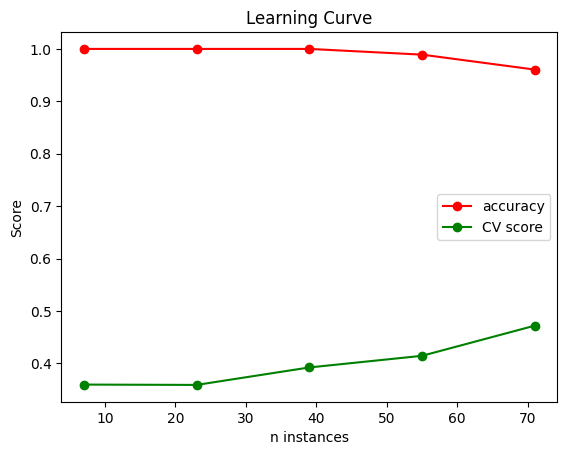

In [74]:
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color="r", label="accuracy")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="CV score")
plt.xlabel("n instances")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()
   

<a name='04'></a>
## Part D. Ensemble learning
Ensemble learning is a powerful machine learning technique that combines the predictions of multiple models to improve overall performance, robustness, and accuracy. Rather than relying on a single model, ensemble learning methods aggregate the results of several models—often called "weak learners"—to produce a stronger predictive model. The key idea behind ensemble learning is that by combining models, the weaknesses of individual models can be offset, leading to better generalization on unseen data. Popular ensemble ML algorithms are the `Random Forest` and `XGBoost`. 
Here’s an improved version of the introduction:

### voting algorithms
Voting algorithms in ensemble learning combine the predictions of multiple classifiers to make a final decision, typically based on the consensus or weighted agreement among models. Two primary types of voting are commonly used: hard voting, where the final prediction is determined by the majority vote, and soft voting, which uses the weighted average of predicted probabilities to determine the outcome. Several sites explain the hard and soft voting algorithm. A clear explanation can be found on https://www.baeldung.com/cs/hard-vs-soft-voting-classifiers


### <span style="background-color: lightyellow;">Ensemble Task</span>
- Review the [Study Case notebook on ensemble learning](..Study_Cases/study_case_bagging_boosting.ipynb).
- Try three different algorithms for classification of your data label.
- Implement a hard and soft voting algorithm for model aggregation.
- Compare the performance of the voting algorithm with that of a boosting or bagging algorithm.
- Update your repository with the voting algorithm class

See also: [ensemle learning video](https://video.hanze.nl/media/Ensemble/0_sue5v33g)


In [106]:
# YOUR CODE HERE WITH THE VOTING ALGORITHMS

import numpy as np

def vote_soft(models, Xtrain, ytrain, Xtest, ytest):
    for model in models:
        model.fit(Xtrain, ytrain)

    max_scores = []
    for model in models:
        yhat = model.predict(Xtest)
        max_scores.append(accuracy_score(ytest, yhat))

    mean_max = []
    for value in max_scores:
        mean_max.append(value/len(max_scores))

    max_index = np.array(mean_max).argmax()
    return models[max_index], max(mean_max)

    
def vote_hard(models, Xtrain, ytrain, Xtest, ytest):
    for model in models:
        model.fit(Xtrain, ytrain)

    max_scores = []
    for model in models:
        yhat = model.predict(Xtest)
        max_scores.append(accuracy_score(ytest, yhat))

    max_index = np.array(max_scores).argmax()
    return models[max_index], max(max_scores)

In [107]:
# YOUR CODE HERE TO COMPARE VOTING OUTCOME WITH A BAGGING OR BOOSTING ALGORITHM FROM SKLEARN
from sklearn.linear_model import LogisticRegression
model1 = RandomForestClassifier()
model2 = LogisticRegression()

models = [model1, model2 ]

print(vote_soft(models, Xtrain, ytrain, Xtest, ytest))
print(vote_hard(models, Xtrain, ytrain, Xtest, ytest))

(RandomForestClassifier(), 0.3055555555555556)
(RandomForestClassifier(), 0.4444444444444444)


<a name='05'></a>
## Part E. Pipelines
The sklearn pipeline function is a tool in machine learning that simplifies the workflow by encapsulating all the steps involved in a single object. It offers advantages such as simplicity, reproducibility, efficiency, flexibility, and integration. The Pipeline is built using a list of (key, value) pairs, where the key is a string containing the name you want to give this step and value is an estimator object (the method to be executed).

### <span style="background-color: lightyellow;">Pipeline Task</span>
- Read the [Study Case notebook for a pipeline functions](..Study_Cases/study_case_pipeline.ipynb) to understand the principle of the pipeline function
- Implement a pipeline which prepares and classifies data 
- Use a `GridSearchCV` object with the `Pipeline` object and a parameter grid to optimize choose the best hyper parameters

In [109]:
# YOUR CODE HERE WITH THE PIPELINE IMPLEMENTATION
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


pipeline = Pipeline([
        ('scaler', StandardScaler()),               
        ('classifier', RandomForestClassifier()) 
    ])

param_grid = [
    {'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [3, 5, 10]},{
            'classifier': [SVC(probability=True, random_state=42)],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']}
]

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(Xtrain, ytrain)

print("Top parameter choice:", grid_search.best_params_)
print("Best cv:", grid_search.best_score_)

c:\Users\James\miniconda3\envs\scanverse\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top parameter choice: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best cv: 0.4628571428571428


## <span style="background-color: lightyellow;">Bring it all together</span>

By now, you've developed code snippets for model evaluation, optimization, and data improvement. Now, leverage these skills to build a classification model using the Clinical and Genetic Lung data. Make sure that you log your experiments. 

Once you're satisfied with the model, upload the relevant code to your repository and or refactor code with new insights. Furthermore, take a moment to reflect on its applicability and potential real-world impact. Update your evaluation document(s) with these findings in your repository. 

## Bonus: ML for operations

If we intend to deploy the model in a real-world application, it's more efficient to save and reuse the trained model rather than retraining it each time. 

- Read the blog: https://neptune.ai/blog/saving-trained-model-in-python
- Write three python files 
    1) a train_model python file 
    2) a use_model python file
    3) a retrain_model python file that adds new data to the original training data and updates the model
- Update your repository
